In [1]:
!python -V

Python 3.9.0


In [21]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [3]:
categorical = ["PULocationID", "DOLocationID"]  # pick-up and drop-off locations
numerical = ["trip_distance"]
target = "duration"

In [4]:
def read_dataframe(fname, categorical, numerical):
    df = pd.read_parquet(fname)
    
    # Convert pick-up/drop-off times to datetime format and build new duration column
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    # Convert duration from datetime to minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # Filter out trips with durations below 1 min or above 1 hour
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df[categorical] = df[categorical].astype(str) # categorical values to strings

    return df

In [5]:
df_train = read_dataframe(
    "../local/data/green_tripdata_2021-01.parquet", categorical, numerical
)
df_val = read_dataframe(
    "../local/data/green_tripdata_2021-02.parquet", categorical, numerical
)
len(df_train), len(df_val)

(73908, 61921)

In [23]:
df_train["PU_DO"] = df_train["PULocationID"] + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + df_val["DOLocationID"]
categorical = ["PU_DO"]

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)
x_val = dv.transform(val_dicts)  # only transform for validation

y_train = df_train[target].values
y_val = df_val[target].values

/home/ubuntu/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


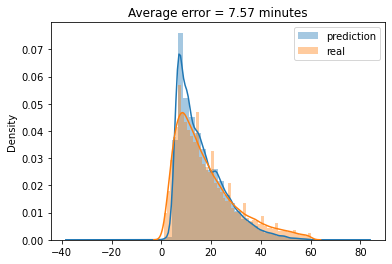

In [24]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
sns.distplot(y_pred, label="prediction")
sns.distplot(y_val, label="real")
plt.legend()
plt.title("Average error = {:.2f} minutes".format(rmse))
plt.show()

/home/ubuntu/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


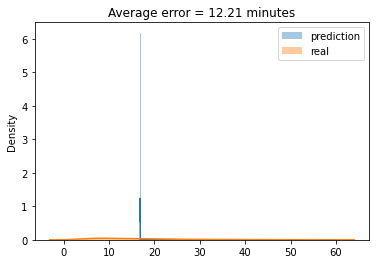

In [22]:
lr = Lasso()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
sns.distplot(y_pred, label="prediction")
sns.distplot(y_val, label="real")
plt.legend()
plt.title("Average error = {:.2f} minutes".format(rmse))
plt.show()